## Theano

Theanoとは？
- GPUへの最適化
- 自動微分

参考ページ
- http://deeplearning.net/software/theano/tutorial/index.html
- http://deeplearning.net/tutorial/logreg.html

In [2]:
import theano

In [3]:
import theano

print(theano.config.floatX)
print(theano.config.device)

float64
cpu


In [4]:
theano.config.floatX='float32'
print(theano.config.floatX)

float32


In [4]:
import keras

Using TensorFlow backend.
/Users/hidehiro/.pyenv/versions/anaconda3-5.0.0/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


#### シンボリック変数
変数を記号として扱う。scalar, vector, matrixなどの次元。
d, fなどを頭につけると数値の型を決めることができる。
データに使う（最後にデータ入れて計算するとき）。更新していく変数（パラメータ）には共有変数を使う

In [5]:
from theano import tensor as T

#double型の0-d array(scalar)の記号x, yを定義
# 'x' は名前
x=T.dscalar('x')
print(type(x))
print(x.type)

<class 'theano.tensor.var.TensorVariable'>
TensorType(float64, scalar)


関数の式を定義できる。

In [6]:
y = T.dscalar('y')
z = x + y
print(theano.pp(z))

(x + y)


In [7]:
z

Elemwise{add,no_inplace}.0

実際に値を計算することもできる

In [8]:
f=theano.function([x,y],z)
f(2,3)

array(5.0)

In [9]:
#行列の足し算。サイズ指定の必要なし
x=T.dmatrix('x')
y=T.dmatrix('y')
z=x + y
f=theano.function([x,y],z)
f([[1,2],[3,4]],[[10,20],[30,40]])

array([[ 11.,  22.],
       [ 33.,  44.]])

In [10]:
x = T.dmatrix('x')
s = 1/(1+T.exp(-x))
logistic = theano.function([x],s)
logistic([[0,1],[-1,-2]])

array([[ 0.5       ,  0.73105858],
       [ 0.26894142,  0.11920292]])

下のような書き方もできる

In [11]:
x1=T.scalar()
w1=T.scalar()
w0=T.scalar()
z1=w1*x1+w0

net_input=theano.function(inputs=[w1,x1,w0],outputs=z1)

print('Net input: %.2f' % net_input(2.0,1.0,0.5))

Net input: 2.50


問題。行列の積は`T.dot(x,y)`で計算できる。これを用いて以下の計算を実装し、いくつかの数値例で確かめよ。

$w, b$はベクトル、$X$は行列として、
$$
y=wX+b
$$

In [12]:
X = T.dmatrix('X')
w = T.dvector('w')
b = T.dvector('b')
y = T.dot(X,w) + b

f = theano.function(inputs=[X,w,b], outputs=y)

In [13]:
f([[1,2],[3,4]],[1,0],[0,1])

array([ 1.,  4.])

### 共有変数
機械学習におけるパラメータなど、頻繁に値を書き換えるものは共有変数として定義する。
sharedメソッドを使って定義。

共有変数は`get_value()`で値を見ることができるが、シンボリック変数はできない。シンボリック変数はコンパイルして値を入れて初めて使える

In [18]:
import numpy as np

w = theano.shared(np.zeros(10),name='w')
print(w.get_value())

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


updateにより共有変数を更新する。

In [15]:
#updatesの使い方

# x はシンボリック変数（更新しない）
x=T.scalar('x')

# w は共有変数（更新していく）
w=theano.shared(0.0,name='w')
y=w*x
f=theano.function([x],y,updates=({w:w+1}))

In [12]:
f(1)

array(0.0)

In [13]:
f(2)

array(2.0)

In [14]:
f(3)

array(6.0)

問題。`f(4)`が何になるか予想し実行して確かめよ。

以下では`theano.function`のいくつかの書き方を紹介する。

In [15]:
x=T.fmatrix('x')
w=theano.shared(np.asarray([[0.0,0.0,0.0]],dtype=theano.config.floatX))
z=x.dot(w.T)
update=[[w,w+1.0]]
net_input=theano.function(inputs=[x],updates=update,outputs=z)
data=np.array([[1,2,3]],dtype=theano.config.floatX)
for i in range(5):
    print('z%d:' % i, net_input(data))

z0: [[ 0.]]
z1: [[ 6.]]
z2: [[ 12.]]
z3: [[ 18.]]
z4: [[ 24.]]


In [16]:
data=np.array([[1,2,3]],dtype=theano.config.floatX)
x=T.fmatrix('x')
w=theano.shared(np.asarray([[0.0,0.0,0.0]],dtype=theano.config.floatX))
z=x.dot(w.T)
update=[[w,w+1.0]]
net_input=theano.function(inputs=[],updates=update,outputs=z,givens={x:data})
for i in range(5):
    print('z%d:' % i, net_input())

z0: [[ 0.]]
z1: [[ 6.]]
z2: [[ 12.]]
z3: [[ 18.]]
z4: [[ 24.]]


In [17]:
import numpy as np

x=T.fmatrix(name='x')
x_sum=T.sum(x,axis=0)

calc_sum=theano.function(inputs=[x],outputs=x_sum)

ary=[[1,2,3],[1,2,3]]
print('Column sum:', calc_sum(ary))

ary=np.array([[1,2,3],[1,2,3]],dtype=theano.config.floatX)
print('Column sum:', calc_sum(ary))

print(x.type())

Column sum: [ 2.  4.  6.]
Column sum: [ 2.  4.  6.]
<TensorType(float32, matrix)>


### 自動微分

In [7]:
#自動微分
# ???: What is wrt? -> with respect to
x=T.dscalar('x')
y=x**2+2*x+3
gy=T.grad(cost=y,wrt=x)

f=theano.function(inputs=[x],outputs=gy)
theano.pp(gy)

'(((fill((((x ** TensorConstant{2}) + (TensorConstant{2} * x)) + TensorConstant{3}), TensorConstant{1.0}) * TensorConstant{2}) * (x ** (TensorConstant{2} - TensorConstant{1}))) + (fill((((x ** TensorConstant{2}) + (TensorConstant{2} * x)) + TensorConstant{3}), TensorConstant{1.0}) * TensorConstant{2}))'

In [19]:
f(1)

array(4.0)

勾配降下法により関数の最小値を求めることができる。

In [17]:
x_init=1.0#初期値
l=0.1#学習率

x=theano.shared(x_init,name='x')
y=x**2
gy=T.grad(cost=y,wrt=x)

train=theano.function(inputs=[],outputs=[y],updates=({x:x-l*gy}))

x_tmp=[]
y_tmp=[]
steps=1000#更新回数
for i in range(steps):
    x_tmp.append(x.get_value())
    y_tmp.append(train())

x_fin=x.get_value()
print('x_final=%9.10f' % x_fin)

x_final=0.0000000000


問題。$f(x)=x^4-7x^2+2x$の最小値を求めよう。初期値や学習率を変化させて結果がどのように変わるか観察せよ。

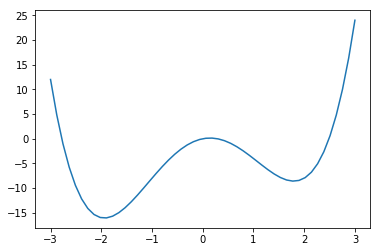

In [20]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def f(x):
    return x**4-7*x**2+2*x

x=np.linspace(-3,3)
y=[f(z) for z in x]
plt.plot(x,y)
plt.show()

In [31]:
x_init=0.2#初期値
l=0.03#学習率

x=theano.shared(x_init,name='x')
y=x**4-7*x**2+2*x
gy=T.grad(cost=y,wrt=x)

train=theano.function(inputs=[],outputs=[y],updates=({x:x-l*gy}))

x_tmp=[]
y_tmp=[]
steps=100#更新回数
for i in range(steps):
    x_tmp.append(x.get_value())
    y_tmp.append(train())

x_fin=x.get_value()
print('x_final=%9.10f' % x_fin)

x_final=1.7948321417


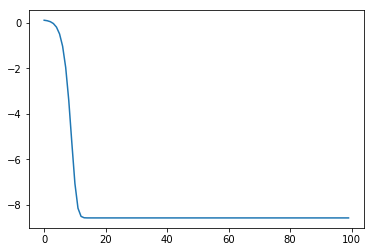

In [32]:
plt.plot(y_tmp)

### 線形回帰の実装
以下では線形回帰の誤差関数を定義し、勾配降下法でパラメータを更新することにより線形回帰モデルの学習を行う。
コードはテキストと同じもの。

In [33]:
n_in=1 # 説明変数の数
W = theano.shared(value=np.random.randn(n_in), name='W')
b = theano.shared(value=.0, name='b')

X=T.dmatrix('X')
y=T.dvector('y')

y_pred = T.dot(X, W) + b
error = T.sum(T.pow(y - y_pred, 2)) # error function E(w)

train_model = theano.function(inputs=[X,y], outputs=error)
train_model([[1],[1],[2]],[1,1,1])

array(38.35851445164143)

In [38]:
y = T.vector('y')
x = T.matrix('x')

n_in=1
w = theano.shared(value=np.random.randn(n_in), name='w')
b = theano.shared(value=.0, name='b')

y_pred = T.dot(x, w) + b
z = T.sum(T.pow(y - y_pred, 2))

gw, gb = T.grad(z, [w, b])
updates = ((w, w - 0.1 * gw), (b, b - 0.1 * gb))

sqer = theano.function(inputs=[x,y], outputs=z, updates=updates)
for i in range(5):
    print(sqer([[1],[2]],[2,4]))

53.80903472854767
7.748501809142526
1.3947304018503675
0.5021029097505246
0.3615140698811379


In [23]:
class LinearRegression(object):
    def __init__(self, X, n_in):
        self.W = theano.shared(value=np.random.randn(n_in), name='W',
                               borrow=True)
        self.b = theano.shared(value=.0, name='b', borrow=True)
        self.y_pred = T.dot(X, self.W) + self.b
        self.params = [self.W, self.b]
        self.X = X
    
    def square_error(self, y):
        return T.sum(T.pow(y - self.y_pred, 2))

In [25]:
import numpy as np
X = T.dmatrix("X")
y = T.dvector("y")
n_in = 1

lr = LinearRegression(X, n_in)
cost = lr.square_error(y)
gw, gb = T.grad(cost, [lr.W, lr.b])

learning_rate=0.01
updates=((lr.W, lr.W - learning_rate * gw),
         (lr.b, lr.b - learning_rate * gb))
train = theano.function(inputs=[lr.X,y], outputs=[cost], updates=updates)
epochs=10
costs=[]

sample=[[i] for i in range(1,6)]
X_train=np.array(sample,dtype=theano.config.floatX)
y_train=np.array([1.1,2.2,2.9,3.8,5.3],dtype=theano.config.floatX)

for i in range(epochs):
    costs.append(train(X_train,y_train))

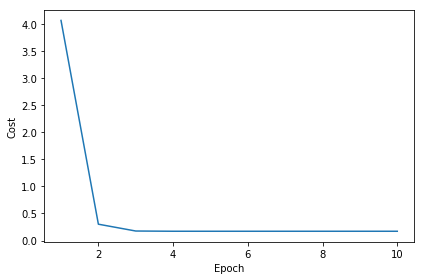

In [42]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(1,len(costs)+1),costs)
plt.xlabel('Epoch')
plt.ylabel('Cost')
plt.tight_layout()

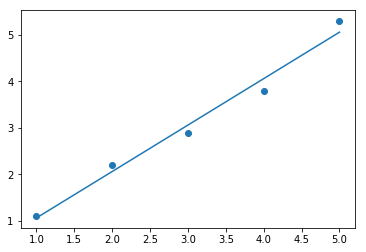

In [43]:
plt.scatter(X_train,y_train)
plt.plot(X_train,np.dot(X_train,lr.W.get_value())+lr.b.get_value())

### ロジスティック回帰の実装

確率的勾配降下法のよるロジスティック回帰の学習を実装する。

In [24]:
class LogisticRegression(object):
    def __init__(self, X, n_in):
        self.W = theano.shared(value=100*np.random.randn(n_in), name='W', borrow=True)
        self.b = theano.shared(value=.0, name='b', borrow=True)
        self.X = X
        self.p = 1 / (1 + T.exp(-T.dot(self.X, self.W) - self.b))
        self.pred = self.p > 0.5 # 半分より上でtrue
        self.params = [self.W, self.b]
    
    def entropy(self, y):
        xent = -y * T.log(self.p) - (1-y) * T.log(1-self.p) # xent is cross entropy, 対数尤度関数を使っている
        return xent.mean() + 0.01 * (self.W ** 2).sum() #L2正則化T.sum(T.pow(y - self.y_pred, 2))

In [25]:
X = T.dmatrix("X")
y = T.dvector("y")

n_in = 1
clf = LogisticRegression(X, n_in)

cost= clf.entropy(y)
gw, gb = T.grad(cost, [clf.W, clf.b])

learning_rate=1
updates=((clf.W, clf.W - learning_rate * gw), (clf.b, clf.b - learning_rate * gb))
train = theano.function(inputs=[clf.X,y], outputs=[cost, clf.pred], updates=updates)
epochs=100
costs=[]

sample=[[i] for i in range(1,6)]
X_train=np.array(sample,dtype=theano.config.floatX)
y_train=np.array([0,0,1,1,1],dtype=theano.config.floatX)

for i in range(epochs):
    costs.append(train(X_train,y_train)[0])

In [18]:
sample=[[i] for i in range(1,6)]
X_train=np.array(sample,dtype=theano.config.floatX)
print(X_train)

[[ 1.]
 [ 2.]
 [ 3.]
 [ 4.]
 [ 5.]]


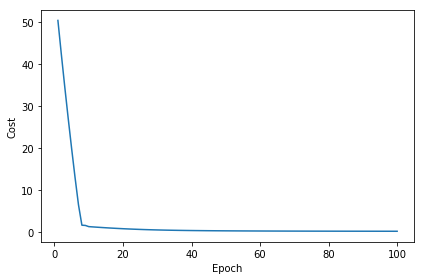

In [53]:
plt.plot(range(1,len(costs)+1),costs)
plt.xlabel('Epoch')
plt.ylabel('Cost')
plt.tight_layout()

In [52]:
predict = theano.function(inputs=[X], outputs=clf.pred)
predict(X_train)

array([False, False,  True,  True,  True], dtype=bool)

In [53]:
p = theano.function(inputs=[X], outputs=clf.p)
p(X_train)

array([ 0.08496356,  0.34806118,  0.75428474,  0.94638221,  0.9902427 ])

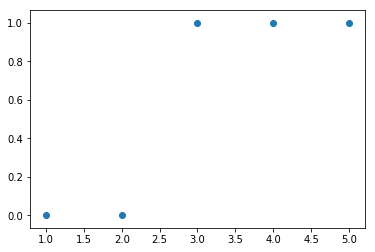

In [26]:
plt.scatter(X_train,y_train)

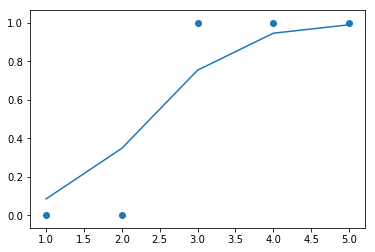

In [56]:
plt.scatter(X_train,y_train)
plt.plot(X_train, p(X_train))

## MNISTのデータを準備

次のページにあるMNISTのデータをダウンロードし、gzipを適当な方法で解凍してください。

http://yann.lecun.com/exdb/mnist/

In [14]:
#mnistのデータを準備する
import os
import struct
def load_mnist(path,kind='train'):
    labels_path=os.path.join(path,'%s-labels.idx1-ubyte' % kind)
    images_path=os.path.join(path,'%s-images.idx3-ubyte' % kind)
    
    with open(labels_path,'rb') as lbpath:
        magic, n=struct.unpack('>II', lbpath.read(8))
        labels=np.fromfile(lbpath,dtype=np.uint8)
    with open(images_path,'rb') as imgpath:
        magic,nu,rows,cols=struct.unpack('>IIII',imgpath.read(16))
        images=np.fromfile(imgpath,dtype=np.uint8).reshape(len(labels),784)
    return images,labels

X_train,y_train=load_mnist('mnist',kind='train')
X_test,y_test=load_mnist('mnist',kind='t10k')

((60000, 784), (60000,), (10000, 784))

In [38]:
valid_set,test_set,train_set=(X_train[:10000,],y_train[:10000]),(X_test,y_test),(X_train[10000:,],y_train[10000:])

In [39]:
#データを共有変数に代入する。GPUを用いる際に計算を高速化させるため
def shared_dataset(data_xy, borrow=True):

    data_x, data_y = data_xy
    shared_x = theano.shared(np.asarray(data_x,
                                           dtype=theano.config.floatX),
                             borrow=borrow)
    shared_y = theano.shared(np.asarray(data_y,
                                           dtype=theano.config.floatX),
                             borrow=borrow)
    
    #分類なのでshared_yは整数にする必要がある。回帰ならfloatのまま
    return shared_x, T.cast(shared_y, 'int32')

test_set_x, test_set_y = shared_dataset(test_set)
valid_set_x, valid_set_y = shared_dataset(valid_set)
train_set_x, train_set_y = shared_dataset(train_set)

## 確率勾配法 SGD

ニューラルネットのパラメータ更新においては確率勾配法と呼ばれる手法が用いられる。

通常の勾配法では全サンプルを用いて損失関数の勾配を計算し、それに基づいてパラメータを更新する。

確率勾配法ではサンプルのうち一部分を用いて損失関数の勾配を計算し、パラメータを更新。
用いるサンプルを都度入れ替える。

### ロジスティック回帰の実装

確率的勾配降下法による多クラスロジスティック回帰を実装しよう。

$$
P(Y=i|x, W,b) = softmax_i(W x + b)\\
= \frac {e^{W_i x + b_i}} {\sum_j e^{W_j x + b_j}}
$$
$$
y_{pred} = argmax_i P(Y=i|x,W,b)
$$

$k$クラス分類に対するソフトマックス関数とは
$x=(x_1,\ldots,x_n)$に対し
$$
s_i(x)=\frac{\exp(W_ix+b_i)}{\sum_j\exp(W_jx+b_j)}
$$
のこと。
これを$i=1,\ldots,k$それぞれのクラスに分類される確率の予測に使う。
$b=(b_1,\ldots,b_k)$であり$W_i=(w_{i1},\ldots,w_{in})$である。
$W_i$をまとめて行列$W$とする。

（二クラスロジスティックだと$\sigma(x)$を$1-\sigma(x)$を二クラスの確率の予測値としていたが、これも上の形でかけることに注意）

$$
\frac{1}{|\mathcal{D}|} \mathcal{L} (\theta=\{W,b\}, \mathcal{D}) =\frac{1}{|\mathcal{D}|} \sum_{i=0}^{|\mathcal{D}|}\log(P(Y=y^{(i)}|x^{(i)}, W,b)) \\
\ell (\theta=\{W,b\}, \mathcal{D})
$$

In [40]:
# 正解率の計算
import theano
import theano.tensor as T
y=T.ivector('y')
y_pred=T.ivector('y_pred')
error_rate=T.mean(T.neq(y,y_pred))
errors=theano.function([y,y_pred],error_rate)
errors([1,0,1,0,1,0,1],[0,0,0,0,0,0,1])

array(0.42857142857142855)

In [41]:
#対数尤度関数を計算する
#対数尤度の-1倍の各サンプルによる平均を返す。
#yはtheano.tensor.TensorTypeで各サンプルの正解ラベル
def negative_log_likelihood(self, y):
#行列Xはj行目がj番目のサンプル。これをinputとする
    p_y_given_x = T.nnet.softmax(T.dot(input, self.W) + self.b)#ソフトマックス関数
    #返り値は行列。各サンプルごとに各クラスの確率を並べた行列になる

    # y.shape[0]はサンプル数n
    # T.arange(n)はシンボリック変数のベクトル[0,1,2,...,n-1]
    # LP(i,y[i])はi番目のサンプルがy[i]になる確率で、それの平均を取るので対数尤度
    return -T.mean(T.log(p_y_given_x)[T.arange(y.shape[0]), y])

In [42]:
#多クラス分類ロジスティック回帰クラス
class LogisticRegression(object):
    def __init__(self, X, n_in, n_out): # n_outは分類クラスの数
        self.W = theano.shared(value=np.zeros((n_in, n_out), dtype=theano.config.floatX),
                               name='W', borrow=True)
        self.b = theano.shared(value=np.zeros((n_out,), dtype=theano.config.floatX),
                               name='b', borrow=True)
        self.p_y_given_x = T.nnet.softmax(T.dot(X, self.W) + self.b) #分類確率を表すシンボル変数
        self.y_pred = T.argmax(self.p_y_given_x, axis=1) #予測クラスを表すシンボル変数
        self.params = [self.W, self.b]
        self.X = X

    def negative_log_likelihood(self, y):
        return -T.mean(T.log(self.p_y_given_x)[T.arange(y.shape[0]), y])

    def errors(self, y):    #ミニバッチでの誤判別率を返す
        if y.ndim != self.y_pred.ndim:
            raise TypeError(
                'y should have the same shape as self.y_pred',
                ('y', y.type, 'y_pred', self.y_pred.type)
            )
        if y.dtype.startswith('int'):
            return T.mean(T.neq(self.y_pred, y))
        else:
            raise NotImplementedError()

In [43]:
x = T.matrix('x')
y = T.ivector('y')

# MNIST は 28 * 28 の入力、10 クラス分類
classifier = LogisticRegression(X=x, n_in=28 * 28, n_out=10)
cost = classifier.negative_log_likelihood(y)
index = T.lscalar() # ミニバッチのインデックスを表すシンボル変数

g_W = T.grad(cost=cost, wrt=classifier.W)
g_b = T.grad(cost=cost, wrt=classifier.b)

learning_rate=0.13
batch_size=600 # ミニバッチ一つあたりのサンプル数
n_epochs=10000

updates = [(classifier.W, classifier.W - learning_rate * g_W),
           (classifier.b, classifier.b - learning_rate * g_b)]

train_model = theano.function(inputs=[index], outputs=cost, updates=updates,
    givens={x: train_set_x[index * batch_size: (index + 1) * batch_size],
            y: train_set_y[index * batch_size: (index + 1) * batch_size]})

test_model = theano.function(inputs=[index], outputs=classifier.errors(y),
    givens={x: test_set_x[index * batch_size: (index + 1) * batch_size],
            y: test_set_y[index * batch_size: (index + 1) * batch_size]})

validate_model = theano.function(inputs=[index], outputs=classifier.errors(y),
    givens={x: valid_set_x[index * batch_size: (index + 1) * batch_size],
            y: valid_set_y[index * batch_size: (index + 1) * batch_size]})

early stoppingについて。

このコードではpatienceで管理する。
scoreが更新されたらpatienceを更新して、パラメータ更新回数を増やす

In [47]:
import timeit

# ミニバッチの数を計算する
n_train_batches = train_set_x.get_value(borrow=True).shape[0] // batch_size
n_valid_batches = valid_set_x.get_value(borrow=True).shape[0] // batch_size
n_test_batches = test_set_x.get_value(borrow=True).shape[0] // batch_size

patience = 5000
patience_increase = 2
improvement_threshold = 0.995
validation_frequency = min(n_train_batches, patience // 2)

best_val_loss = np.inf
test_score = 0.
start_time = timeit.default_timer()

done_looping = False
epoch = 0
while (epoch < n_epochs) and (not done_looping):
    epoch = epoch + 1
    for minibatch_index in range(n_train_batches):

        minibatch_avg_cost = train_model(minibatch_index)
        # iteration number
        iter = (epoch - 1) * n_train_batches + minibatch_index

        if (iter + 1) % validation_frequency == 0:
            this_val_loss = np.mean([validate_model(i) for i in range(n_valid_batches)])

            print('epoch %i, minibatch %i/%i, validation error %f %%' %
                  (epoch, minibatch_index + 1, n_train_batches, this_val_loss * 100.))
            
            # val_loss が最小なら、best_val_lossを更新する
            if this_val_loss < best_val_loss:
                # さらに閾値より小さければ、patienceを大きくする（iterが大きい時のみ）
                if this_val_loss < best_val_loss * improvement_threshold:
                    patience = max(patience, iter * patience_increase)

                best_val_loss = this_val_loss

                test_score = np.mean([test_model(i) for i in range(n_test_batches)])

                print((' epoch %i, minibatch %i/%i, test error of best model %f %%') %
                      (epoch, minibatch_index + 1, n_train_batches, test_score * 100.))

        if patience <= iter:
            done_looping = True
            break

end_time = timeit.default_timer()
print(('Optimization complete with best validation score of %f %%,'
       'with test performance %f %%') % (best_val_loss * 100., test_score * 100.))
print('The code run for %d epochs, with %f epochs/sec' %
      (epoch, 1. * epoch / (end_time - start_time)))
print(('The code for file ran for %.1fs' % ((end_time - start_time))))

epoch 1, minibatch 83/83, validation error 8.895833 %
 epoch 1, minibatch 83/83, test error of best model 8.718750 %
epoch 2, minibatch 83/83, validation error 9.437500 %
epoch 3, minibatch 83/83, validation error 8.729167 %
 epoch 3, minibatch 83/83, test error of best model 8.656250 %
epoch 4, minibatch 83/83, validation error 9.093750 %
epoch 5, minibatch 83/83, validation error 9.791667 %
epoch 6, minibatch 83/83, validation error 9.447917 %
epoch 7, minibatch 83/83, validation error 12.020833 %
epoch 8, minibatch 83/83, validation error 9.333333 %
epoch 9, minibatch 83/83, validation error 9.791667 %
epoch 10, minibatch 83/83, validation error 9.541667 %
epoch 11, minibatch 83/83, validation error 9.489583 %
epoch 12, minibatch 83/83, validation error 10.333333 %
epoch 13, minibatch 83/83, validation error 9.197917 %
epoch 14, minibatch 83/83, validation error 9.072917 %
epoch 15, minibatch 83/83, validation error 9.416667 %
epoch 16, minibatch 83/83, validation error 11.458333 %


In [46]:
predict_model = theano.function(
    inputs=[classifier.X],
    outputs=classifier.y_pred)

test_set_x_value = test_set_x.get_value()

predicted_values = predict_model(test_set_x_value[:10])
print("Predicted values for the first 10 examples in test set:")
print(predicted_values)

Predicted values for the first 10 examples in test set:
[7 2 1 0 4 1 4 9 6 9]


### 多層パーセプトロンの実装

活性化関数$s(x)$としてtanhやsigmaoid、ReLUなど

隠れ層が一層のモデルをここでは実装する。
$$
f(x) = G( b^{(2)} + W^{(2)}( s( b^{(1)} + W^{(1)} x)))
$$

In [48]:
#http://deeplearning.net/tutorial/mlp.html
class HiddenLayer(object):
    def __init__(self, rng, input, n_in, n_out, W=None, b=None,
                 activation=T.tanh):
        # 活性化関数は tanh(dot(input,W) + b) を使う
        # 重さ行列 W はサイズ (n_in,n_out) 行列
        # 切片 b はサイズ (n_out,)
        # rng はパラメータ初期化のための乱数生成器
        # input はデータ
        # 持ってる属性は input, W, b, output, params
        
        self.input = input
        
        # パラメータの初期化。活性化関数によって最適な初期値が違う
        if W is None:
            W_values = np.asarray(
                rng.uniform(
                    low=-np.sqrt(6. / (n_in + n_out)),
                    high=np.sqrt(6. / (n_in + n_out)),
                    size=(n_in, n_out)
                ),
                dtype=theano.config.floatX
            )
            if activation == theano.tensor.nnet.sigmoid:
                W_values *= 4

            W = theano.shared(value=W_values, name='W', borrow=True)

        if b is None:
            b_values = np.zeros((n_out,), dtype=theano.config.floatX)
            b = theano.shared(value=b_values, name='b', borrow=True)

        self.W = W
        self.b = b

        lin_output = T.dot(input, self.W) + self.b
        self.output = (
            lin_output if activation is None
            else activation(lin_output)
        )
        # parameters of the model
        self.params = [self.W, self.b]

In [49]:
# ここでは隠れ層が一層のMLP
class MLP(object):
    def __init__(self, rng, input, n_in, n_hidden, n_out):
        # rngは乱数生成器
        # n_inは入力層のunitの数, n_hiddenは隠れ層のunitの数, n_outは出力層のunitの数
        
        # tanhを活性化関数にもつHidenLayerクラスのオブジェクトとLogisticRegressionクラスをつなぐ
        self.hiddenLayer = HiddenLayer(
            rng=rng,
            input=input,
            n_in=n_in,
            n_out=n_hidden,
            activation=T.tanh
        )

        #出力層
        self.logRegressionLayer = LogisticRegression(
            X=self.hiddenLayer.output,
            n_in=n_hidden,
            n_out=n_out
        )

        # L1正則化
        self.L1 = (
            abs(self.hiddenLayer.W).sum()
            + abs(self.logRegressionLayer.W).sum()
        )

        # L2正則化
        self.L2_sqr = (
            (self.hiddenLayer.W ** 2).sum()
            + (self.logRegressionLayer.W ** 2).sum()
        )

        self.negative_log_likelihood = (
            self.logRegressionLayer.negative_log_likelihood
        )
        self.errors = self.logRegressionLayer.errors

        self.params = self.hiddenLayer.params + self.logRegressionLayer.params

        self.input = input

In [50]:
# 確率勾配法でMLPのトレーニング
learning_rate=0.01
# L1_regはL1正則化の強さ、L2_regはL2正則化の強さ
L1_reg=0.00
L2_reg=0.0001
n_epochs=1000
batch_size=20
n_hidden=500

In [52]:
n_train_batches = train_set_x.get_value(borrow=True).shape[0] // batch_size
n_valid_batches = valid_set_x.get_value(borrow=True).shape[0] // batch_size
n_test_batches = test_set_x.get_value(borrow=True).shape[0] // batch_size

index = T.lscalar()
x = T.matrix('x')
y = T.ivector('y')

rng = np.random.RandomState(1234)

classifier = MLP(rng=rng, input=x, n_in=28 * 28, 
                 n_hidden=n_hidden, n_out=10)
    
cost = (classifier.negative_log_likelihood(y)
        + L1_reg * classifier.L1 + L2_reg * classifier.L2_sqr)

test_model = theano.function(
    inputs=[index],
    outputs=classifier.errors(y),
    givens={x: test_set_x[index * batch_size:(index + 1) * batch_size],
            y: test_set_y[index * batch_size:(index + 1) * batch_size]})

validate_model = theano.function(
    inputs=[index],
    outputs=classifier.errors(y),
    givens={x: valid_set_x[index * batch_size:(index + 1) * batch_size],
            y: valid_set_y[index * batch_size:(index + 1) * batch_size]})

gparams = [T.grad(cost, param) for param in classifier.params]

# A = [a1, a2, a3, a4] と B = [b1, b2, b3, b4] に対し
# zip(A,B) = [(a1, b1), (a2, b2), (a3, b3), (a4, b4)]
updates = [(param, param - learning_rate * gparam)
           for param, gparam in zip(classifier.params, gparams)]

train_model = theano.function(
    inputs=[index],
    outputs=cost,
    updates=updates,
    givens={x: train_set_x[index * batch_size: (index + 1) * batch_size],
            y: train_set_y[index * batch_size: (index + 1) * batch_size]})

In [53]:
print('... training')

patience = 10000
patience_increase = 2
improvement_threshold = 0.995
validation_frequency = min(n_train_batches, patience // 2)

best_validation_loss = np.inf
best_iter = 0
test_score = 0.
start_time = timeit.default_timer()

epoch = 0
done_looping = False

while (epoch < n_epochs) and (not done_looping):
    epoch = epoch + 1
    for minibatch_index in range(n_train_batches):

        minibatch_avg_cost = train_model(minibatch_index)
        iter = (epoch - 1) * n_train_batches + minibatch_index

        if (iter + 1) % validation_frequency == 0:
            validation_losses = [validate_model(i) for i
                                 in range(n_valid_batches)]
            this_validation_loss = np.mean(validation_losses)

            print('epoch %i, minibatch %i/%i, validation error %f %%' %
                  (epoch, minibatch_index + 1, n_train_batches,
                   this_validation_loss * 100.))

            if this_validation_loss < best_validation_loss:
                if (this_validation_loss < best_validation_loss * improvement_threshold):
                    patience = max(patience, iter * patience_increase)

                best_validation_loss = this_validation_loss
                best_iter = iter

                test_losses = [test_model(i) for i
                               in range(n_test_batches)]
                test_score = np.mean(test_losses)

                print((' epoch %i, minibatch %i/%i, test error of best model %f %%') %
                      (epoch, minibatch_index + 1, n_train_batches, test_score * 100.))

        if patience <= iter:
            done_looping = True
            break

end_time = timeit.default_timer()
print(('Optimization complete. Best validation score of %f %% '
       'obtained at iteration %i, with test performance %f %%') %
      (best_validation_loss * 100., best_iter + 1, test_score * 100.))
print(('The code for file ' +
       ' ran for %.2fm' % ((end_time - start_time) / 60.)))

... training
epoch 1, minibatch 2500/2500, validation error 10.570000 %
 epoch 1, minibatch 2500/2500, test error of best model 9.750000 %
epoch 2, minibatch 2500/2500, validation error 10.490000 %
 epoch 2, minibatch 2500/2500, test error of best model 9.660000 %
epoch 3, minibatch 2500/2500, validation error 9.150000 %
 epoch 3, minibatch 2500/2500, test error of best model 9.140000 %
epoch 4, minibatch 2500/2500, validation error 9.630000 %
epoch 5, minibatch 2500/2500, validation error 9.490000 %
Optimization complete. Best validation score of 9.150000 % obtained at iteration 7500, with test performance 9.140000 %
The code for file  ran for 0.65m
